In [1]:
import numpy as np
max_pad_len = 174

def extract_features(file_name):

    try:
        audio, sample_rate = librosa.load(file_name)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None

    return mfccs

In [2]:
# Load various imports
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset
fulldatasetpath = './dataset_forest/audio/'

metadata = pd.read_csv('./dataset_forest/metadata/dataset_forest.csv')

features = []

# Iterate through each sound file and extract the features
for index, row in metadata.iterrows():

    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))

    class_label = row["class"]
    data = extract_features(file_name)

    features.append([data, class_label])

# Convert into a Panda dataframe
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  4374  files


In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

# split the dataset
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

Using TensorFlow backend.


In [5]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [6]:
# Display model architecture summary
model.summary()

# Calculate pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 86, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 41, 64)         8

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

#num_epochs = 12
#num_batch_size = 128

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
14/14 [==============================] - ETA: 0s - loss: 2.6468 - accuracy: 0.3264
Epoch 00001: val_loss improved from inf to 1.35064, saving model to saved_models\weights.best.basic_cnn.hdf5
14/14 [==============================] - 18s 1s/step - loss: 2.6468 - accuracy: 0.3264 - val_loss: 1.3506 - val_accuracy: 0.4606
Epoch 2/72
14/14 [==============================] - ETA: 0s - loss: 1.3410 - accuracy: 0.4673
Epoch 00002: val_loss improved from 1.35064 to 1.23963, saving model to saved_models\weights.best.basic_cnn.hdf5
14/14 [==============================] - 19s 1s/step - loss: 1.3410 - accuracy: 0.4673 - val_loss: 1.2396 - val_accuracy: 0.4937
Epoch 3/72
14/14 [==============================] - ETA: 0s - loss: 1.1470 - accuracy: 0.5304
Epoch 00003: val_loss improved from 1.23963 to 1.21820, saving model to saved_models\weights.best.basic_cnn.hdf5
14/14 [==============================] - 16s 1s/step - loss: 1.1470 - accuracy: 0.5304 - val_loss: 1.2182 - val_accuracy: 0.4

In [8]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name)
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = np.argmax(model.predict(prediction_feature), axis=-1)
    predicted_class = le.inverse_transform(predicted_vector)
    print("The predicted class is:", predicted_class[0], '\n')

    predicted_proba_vector = model.predict(prediction_feature)
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

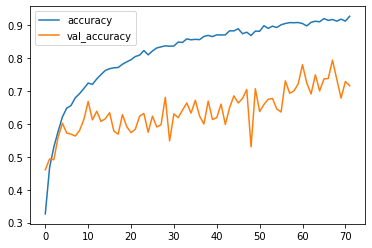

In [10]:
import matplotlib.pyplot as plt

metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [165]:
y_test_arg = np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(x_test),axis=1)

In [166]:
le.classes_ = np.load('./saved_models/classes.npy')
sound_class = le.classes_.tolist()
print(le.classes_)
print(sound_class)

['angin' 'gergaji' 'orang_berbicara' 'suara_alam' 'suara_tembakan']
['angin', 'gergaji', 'orang_berbicara', 'suara_alam', 'suara_tembakan']


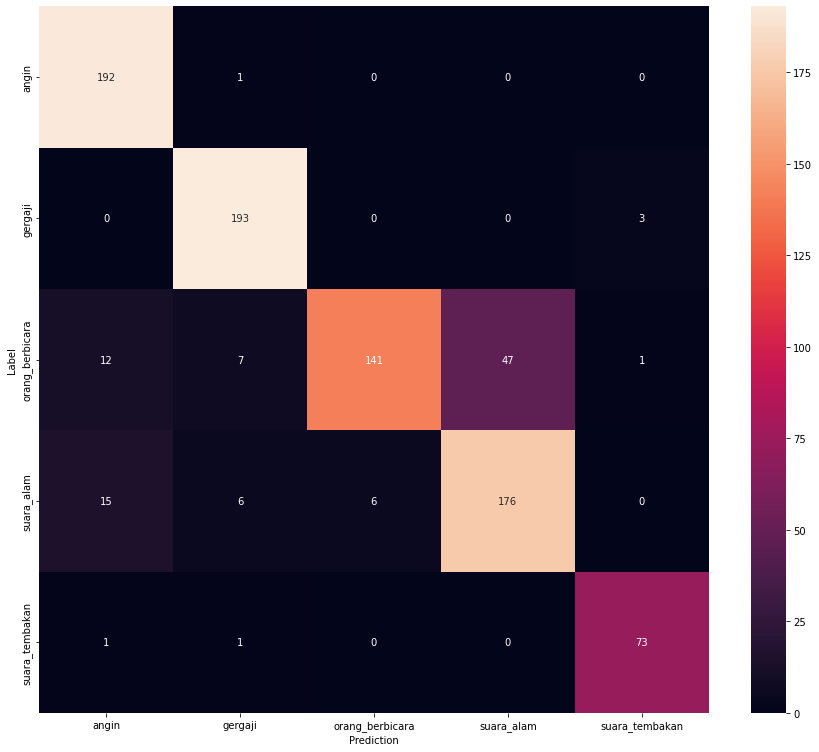

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_test_arg, Y_pred)
plt.figure(figsize=(15, 13))
sns.heatmap(confusion_mtx, xticklabels=le.classes_, yticklabels=le.classes_,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [168]:
filename = 'Evaluation audio/hasil_gergaji/25 meter/gergaji (1).wav'
print_prediction(filename)

The predicted class is: angin 

angin 		 :  0.93031740188598632812500000000000
gergaji 		 :  0.01816755905747413635253906250000
orang_berbicara 		 :  0.02021523192524909973144531250000
suara_alam 		 :  0.03124624304473400115966796875000
suara_tembakan 		 :  0.00005357536429073661565780639648


In [169]:
filename = 'Evaluation audio/hasil_gergaji/25 meter/gergaji (2).wav'
print_prediction(filename)

The predicted class is: angin 

angin 		 :  0.85399419069290161132812500000000
gergaji 		 :  0.01342162676155567169189453125000
orang_berbicara 		 :  0.08808822929859161376953125000000
suara_alam 		 :  0.04440875723958015441894531250000
suara_tembakan 		 :  0.00008720094047021120786666870117


In [170]:
filename = 'Evaluation audio/hasil_gergaji/25 meter/gergaji (3).wav'
print_prediction(filename)

The predicted class is: angin 

angin 		 :  0.54726415872573852539062500000000
gergaji 		 :  0.05163333937525749206542968750000
orang_berbicara 		 :  0.09852562844753265380859375000000
suara_alam 		 :  0.30233526229858398437500000000000
suara_tembakan 		 :  0.00024162675254046916961669921875


In [171]:
filename = 'Evaluation audio/hasil_gergaji/25 meter/gergaji (4).wav'
print_prediction(filename)

The predicted class is: angin 

angin 		 :  0.54351943731307983398437500000000
gergaji 		 :  0.09698578715324401855468750000000
orang_berbicara 		 :  0.09293625503778457641601562500000
suara_alam 		 :  0.26619917154312133789062500000000
suara_tembakan 		 :  0.00035941399983130395412445068359


In [172]:
filename = 'Evaluation audio/hasil_gergaji/25 meter/gergaji (5).wav'
print_prediction(filename)

The predicted class is: angin 

angin 		 :  0.97106182575225830078125000000000
gergaji 		 :  0.00581945106387138366699218750000
orang_berbicara 		 :  0.00733307702466845512390136718750
suara_alam 		 :  0.01574345491826534271240234375000
suara_tembakan 		 :  0.00004219980837660841643810272217


In [173]:
filename = 'Evaluation audio/hasil_gergaji/25 meter/gergaji (6).wav'
print_prediction(filename)

The predicted class is: angin 

angin 		 :  0.97595971822738647460937500000000
gergaji 		 :  0.01267368439584970474243164062500
orang_berbicara 		 :  0.00441657006740570068359375000000
suara_alam 		 :  0.00688995840027928352355957031250
suara_tembakan 		 :  0.00006011445657350122928619384766


In [174]:
filename = 'Evaluation audio/hasil_gergaji/25 meter/gergaji (7).wav'
print_prediction(filename)

The predicted class is: angin 

angin 		 :  0.99793660640716552734375000000000
gergaji 		 :  0.00023428226995747536420822143555
orang_berbicara 		 :  0.00171704380773007869720458984375
suara_alam 		 :  0.00011202994210179895162582397461
suara_tembakan 		 :  0.00000013887523664379841648042202


In [175]:
filename = 'Evaluation audio/hasil_gergaji/25 meter/gergaji (8).wav'
print_prediction(filename)

The predicted class is: angin 

angin 		 :  0.99704664945602416992187500000000
gergaji 		 :  0.00047269396600313484668731689453
orang_berbicara 		 :  0.00220255809836089611053466796875
suara_alam 		 :  0.00027734352624975144863128662109
suara_tembakan 		 :  0.00000078285427207447355613112450


In [176]:
filename = 'Evaluation audio/hasil_gergaji/25 meter/gergaji (9).wav'
print_prediction(filename)

The predicted class is: angin 

angin 		 :  0.92294913530349731445312500000000
gergaji 		 :  0.00395456887781620025634765625000
orang_berbicara 		 :  0.06856095045804977416992187500000
suara_alam 		 :  0.00453243125230073928833007812500
suara_tembakan 		 :  0.00000284320572063734289258718491


In [177]:
filename = 'Evaluation audio/hasil_gergaji/25 meter/gergaji (10).wav'
print_prediction(filename)

The predicted class is: angin 

angin 		 :  0.87054777145385742187500000000000
gergaji 		 :  0.00122652098070830106735229492188
orang_berbicara 		 :  0.12644805014133453369140625000000
suara_alam 		 :  0.00176921708043664693832397460938
suara_tembakan 		 :  0.00000845451631903415545821189880


In [1]:
pip freeze

absl-py==1.0.0
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
astunparse==1.6.3
attrs==21.4.0
audioread==2.1.9
azure-common==1.1.27
azure-core==1.21.1
azure-storage-blob==2.1.0
azure-storage-common==2.1.0
backcall==0.2.0
bleach==4.1.0
cachetools==4.2.4
certifi==2021.10.8
cffi==1.15.0
charset-normalizer==2.0.10
colorama==0.4.4
cryptography==36.0.1
cycler==0.11.0
debugpy==1.5.1
decorator==5.1.1
defusedxml==0.7.1
entrypoints==0.3
fonttools==4.28.5
gast==0.3.3
google-auth==2.3.3
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
grpcio==1.43.0
h5py==2.10.0
idna==3.3
importlib-metadata==4.10.0
importlib-resources==5.4.0
ipykernel==6.6.1
ipython==7.31.0
ipython-genutils==0.2.0
ipywidgets==7.6.5
isodate==0.6.1
jedi==0.18.1
Jinja2==3.0.3
joblib==1.1.0
jsonschema==4.3.3
jupyter==1.0.0
jupyter-client==7.1.0
jupyter-console==6.4.0
jupyter-core==4.9.1
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.2
Keras==2.3.1
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2
kiwisolver==1.3.2
librosa==0.7